<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/R/01ZLMA_ex12_Loglinear_models_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 12
Exercise 12 of the course 01ZLMA. 

## Contents

* Log-linear models for Contingency tables
 ---


Dataset and example from Chapter 10

Peter K. Dunn • Gordon K. Smyth, Generalized Linear ModelsWith Examples in R

https://link.springer.com/content/pdf/10.1007%2F978-1-4419-0118-7.pdf

In [ ]:
install.packages("GLMsData")
library(GLMsData)
library(tidyverse)

## Two Dimensional Tables: 

A table of counts may arise from several possible sampling schemes, each suggesting a different probability model. 

* The n observations are allocated to factors A and B as the observations
randomly arrive; neither row nor column totals are fixed.
* A fixed total number of m observations are cross-classified by the factors
A and B.
* The row totals are fixed, and observations allocated to factor B within
each level of A. (Alternatively, the column total are fixed, and observations
allocated to factor A within each level of B.)

Example 10.2.
Consider a 2×2 table, where data were collected between
December 1996 and January 1997, and comprise a two-dimensional (or
two-way) table of counts collating the `attitude` of Australians to genetically modified foods (factor A) according to their `income` (factor B) 


In [ ]:
gm <- data.frame(counts = c(263, 258, 151, 222),
                 attitude = c("for","for","against","against"),
                 income = c("high","low","high","low")) %>%
      mutate(attitude = as.factor(attitude),
             income = as.factor(income))

gm
str(gm)           


In [ ]:
gm_table <- xtabs(counts ~ attitude + income, data =gm)
gm_table

The percentage of low and high income respondents who are `for` and
`against` gm foods by `income` level using prop.table():

In [ ]:
round(prop.table(gm_table, margin=2)*100, 1) # margin=2 means columns


In [ ]:
interaction.plot(gm$attitude, gm$income,gm$counts)


### Contingency table

Model: $Y_{ij} \sim Poisson(\lambda_{ij} )$

Null (independence): $H_0 :\lambda_{ij} = \delta \cdot \alpha_i \cdot \beta_j , \sum_i \alpha_i = 1, \sum_j \beta_j = 1.$
Alternative: $H_a : \lambda_{ij} \in \mathbb{R}^+$

Test statistic: Pearson’s $X^2$ : $X^2 = \sum_{ij} \frac{(Y_{ij}-E_{ij})^2}{E_{ij}} \overset{H_0}{\approx} \chi^2_1$, where $E_{ij}$ is the estimated expected value under independence.





In [ ]:
Y = c(151,222,263,258)
N = sum(Y)

pi_a = c((151+222)/N,(263+258)/N)
pi_i = c((151+263)/N,(222+258)/N)

E = N*c(pi_a[1]*pi_i[1], pi_a[1]*pi_i[2], pi_a[2]*pi_i[1], pi_a[2]*pi_i[2])
# Pearson's X^2
E
X2 = sum((Y - E)^2/E)
p_val_X2 =  1-pchisq(X2,1)
c(X2,p_val_X2)

In [ ]:
N

In [ ]:
matrix(Y,2,2)
chisq.test(matrix(Y,2,2), correct=FALSE)
#chisq.test(matrix(Y,2,2), correct=T)


### GLM

In [ ]:
gm_1 <- glm(counts ~ attitude + income, family=poisson,data = gm)
summary(gm_1)
anova(gm_1, test="Chisq")


In [ ]:
data.frame(true = gm$counts, fitted_GLM= fitted(gm_1),expected_X2 = E[c(3,4,1,2)])



Poisson GLM  has the same fitted values as we the model computed by hand above.



In [ ]:
DEV = sum(2*(Y*log(Y/E)+Y-E))
c(X2, DEV, deviance(gm_1)) %>% round(4)
# Close but not the same

Test statists are numerically close, but not the same.

Both of these statistics have asymptotic $\chi^2$ distributions, reasonably well-approximatedwhen all expected frequencies are large.


In practice  global tests (such as Deviance or Pearson $\chi^2$) are less useful for comparing competing models.  Usully we compare competing models directly with Deviance test or AIC or BIC, respectivelly.

In [ ]:

c_val_deviance = qchisq(0.05,4-3,ncp=0,lower.tail = F)
p_val_deviance = pchisq(DEV,4-3,ncp=0,lower.tail = F)


In [ ]:
data.frame(test = c("Pearson Chi2","Deviance"), 
           statistic = c(X2, DEV),
           p_val = c( p_val_X2,p_val_deviance))


The inference is the same from both models

### Interpretation

In [ ]:
coef(gm_1)


Model $gm_1$: $log(\hat{\mu}_{ij}) = \alpha + \beta_i x_i + \beta_j x_j = 5.151 + 0.3342x_i + 0.1479x_j,$

where  $x_i = 1$ for row $i = 2$ (for gm foods) and is zero otherwise, and $x_j = 1$ for column $j = 2$ (low income) and is zero otherwise.

In [ ]:
exp(5.1517)
exp(0.3342)
exp(0.1479)

Interpretation of model $gm_1$:

$ \hat{\mu}_{ij} = exp(5.486) \cdot exp(0.3342x_i) \cdot exp(0.1479x_j)
= 172.7 \cdot 1.396^{x_i} \cdot 1.159^{x_j}$,   $ \ \ \ \ x_1,x_2 \in \{0,1\}$.

Under this model, the fitted values for $\hat{\mu}_{i2}$ are always 1.159 times the fitted values for $\hat{\mu}_{i1}$, for either value of $x_1$. This ratio of the corresponding column marginal totals is:


In [ ]:
sum(gm$counts[gm$income=="low"]) / sum(gm$counts[gm$income=="high"])


The interpretaion of the estimated coefficients are following:

$exp(\beta_i) = \frac{\pi_{i \cdot}}{\pi_{1 \cdot}} = \frac{P[X=i]}{P[X=1]}$


$exp(\beta_j) = \frac{\pi_{i \cdot}}{\pi_{1 \cdot}} = \frac{P[X=i]}{P[X=1]}$

In [ ]:
exp(coef(gm_1)[2])
pi_a[2]/pi_a[1]

exp(coef(gm_1)[3])
pi_i[2]/pi_i[1]

If we want to determine the relationship between income and attitudes
towards gm foods, we have to investigate the  the interaction term in the model.



In [ ]:
gm_2 <- glm(counts ~ attitude * income, family=poisson,data = gm)



Interaction model is Saturated model and its deviance is zero. We can apply MLE theory sincethe number of parameters is fixed (its constant).



In [ ]:
summary(gm_2)
anova(gm_2, test="Chisq")

Summary

* The interaction term is necessary in the model. 

* No residual deviance remains and no residual degrees of freedom remain, so the fit is perfect. 

* The number of coefficients in the saturated model is the same as the
number of entries in the table

* The contingency table cannot be summarized by a smaller set of
model coefficients.

* The data suggest an association between income levels and attitude towards gm foods. 

Interprettion of the interaction model `X ~ attitude` and `Z ~ income`:

$exp(\beta_i) = \frac{\pi_{i 1}}{\pi_{1 1}} = \frac{P[X=i|Z =1]}{P[X=1 | Z=1]}$


$exp(\beta_j) = \frac{\pi_{1 j}}{\pi_{1 1}} = \frac{P[X=1 | Z =j]}{P[X=1 | Z =1]}$

$exp(\beta_{ij}) = \frac{\pi_{ij} \pi_{11}}{\pi_{i 1} \pi_{1j}}$

Possible cases:
* No Marginal Totals Are Fixed - previous example, no requirement in the model
* Conditioning on the Grand Total - Poisson model is  appropriate  and it is equivalent to a multinomial model iff the constant term is in the model.
* The Column (or Row) Totals Are Fixed - Poisson model is appropriate iff the coefficients in the linear predictor corresponding to fixed margins are included in the linear predictor.

## Three-Dimensional Tables

Consider three categorical random variables $A \in \{1, \ldots, I\}$, $B \in \{1, \ldots, J\}$, $C \in \{1, \ldots, K\}$ and  $n$ realizaions of this triplet to obtain a contingency table.

If the factors have I, J and K levels respectively, the table
is an I × J × K table and  $\mu_{i,j,k} $ refers to the expected count in the cell (i, j, k).



We assume following possible models:

* Mutal Independence (A,B,C) 
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i \cdot \cdot}) + log(\pi_{\cdot j \cdot}) + log(\pi_{ \cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k  $$

* Partial Independence (AC,B)
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i j \cdot}) + log(\pi_{\cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \beta)_{ij}  $$

* Conditional Independence (AC,BC)
$$\log(\mu_{ijk}) = log(n) + log(\pi_{i \cdot k}) + log(\pi_{\cdot j k}) + log(\pi_{\cdot \cdot k}) = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha \gamma)_{ik} + (\beta \gamma)_{jk}   $$


* Uniform Association (AB,AC,BC)
$$\log(\mu_{ijk}) =  \mu + \alpha_i + \beta_j + \gamma_k +  (\alpha \beta)_{ij} +(\alpha \gamma)_{ik} + (\beta \gamma)_{jk}   $$


* The Saturated Model (ABC)
$$\log(\mu_{ijk}) =  \mu + \alpha_i + \beta_j + \gamma_k +  (\alpha \beta)_{ij} +(\alpha \gamma)_{ik} + (\beta \gamma)_{jk} + (\alpha \beta \gamma)_{ijk}   $$




In [ ]:
data(kstones)
kstones
str(kstones)
table(kstones)

Model (ABC), i.e. (Size,Method,Outcome)

In [ ]:
ks_mutind <- glm( Counts ~ Size + Method + Outcome, family=poisson, data=kstones)
summary(ks_mutind )

In [ ]:
# Test model:
1- pchisq(deviance(ks_mutind),df.residual(ks_mutind))


In [ ]:
data.frame(fitted = fitted(ks_mutind), measured = kstones$Counts)

To plot residuals with Pearson test we can use function `mosaic`

In [ ]:
install.packages("vcdExtra")
library(vcdExtra)
mosaic(ks_mutind, shade=TRUE, formula = ~ Size + Method + Outcome,residuals_type="rstandard",
 labeling=labeling_residuals,main="Model: [Size][Method][Outcome]")

Not enough good model ... Find another one ....

Model (AB,C), i.e. (Size*Method,Outcome)

In [ ]:
ks_SM <- glm( Counts ~ Size * Method + Outcome, family=poisson, data=kstones )
#ks_SO <- update(ks_SM, . ~ Size * Outcome + Method)
#ks_OM <- update(ks_SM, . ~ Outcome * Method + Size)

summary(ks_SM)
#summary(ks_SO)
#summary(ks_OM)



In [ ]:
1- pchisq(deviance(ks_SM),df.residual(ks_SM))

anova(ks_SM,ks_mutind,test="Chisq")
drop1(ks_SM,test="Chisq")

mosaic(ks_SM, shade=TRUE, formula = ~ Size + Method + Outcome,residuals_type="rstandard")

Model (AB,AC), i.e. (Size* Method, Size * Outcome)

In [ ]:
ks_noMO <- glm( Counts ~ Size * (Method + Outcome), family=poisson, data=kstones )  #f
#ks_noOS <- update(ks.noMO, . ~ Method * (Outcome + Size) )
#ks_noMS <- update(ks.noMO, . ~ Outcome * (Method + Size) )

summary(ks_noMO)
#summary(ks_noOS)
#summary(ks_noMS)



In [ ]:
1- pchisq(deviance(ks_noMO),df.residual(ks_noMO))

anova(ks_noMO,ks_SM,test="Chisq")
drop1(ks_noMO,test="Chisq")

mosaic(ks_noMO, shade=TRUE, formula = ~ Size + Method + Outcome,residuals_type="rstandard")

Model (AB,AC,BC), i.e. (Size * Method,Size * Outcome, Method * Outcome)

In [ ]:
ks_no3 <- glm( Counts ~ Size*Method*Outcome - Size:Method:Outcome,family=poisson, data=kstones )
#ks_no3b <- glm( Counts ~ (Size+Method+Outcome)^2,family=poisson, data=kstones )

summary(ks_no3)
#summary(ks_no3b)


In [ ]:
anova(ks_noMO,ks_no3,test="Chisq")
drop1(ks_no3,test="Chisq")


Saturated model

If the saturated model is appropriate, then the data cannot be
presented in a simpler form than giving the original I × J × K table.



In [ ]:
ks_sat <- glm( Counts ~ Size * Method * Outcome, family=poisson, data=kstones )
#deviance(ks_sat)
#df.residual(ks_sat)


In [ ]:
anova(ks_noMO,ks_sat,test="Chisq")
drop1(ks_sat,test="Chisq")

Today's tasks:

* From previous 5 models choose the right one. What will be your approach?
Hint: Find the the simplest suitable model. 

* Interpret your final model. Which variables are independent? 

* Which Method is more successfull, A or B? Which method is more successfull for Large stones? 

* What is the odds ratio of succes if we consider small stone compare to large one?

* Use Logit model for previous data and compare results from Logit model to Poisson model. Is the outcome from the logit model same?

 Equivalent loglinear and logit models for a three-way table, with `C` as a binary response variable.

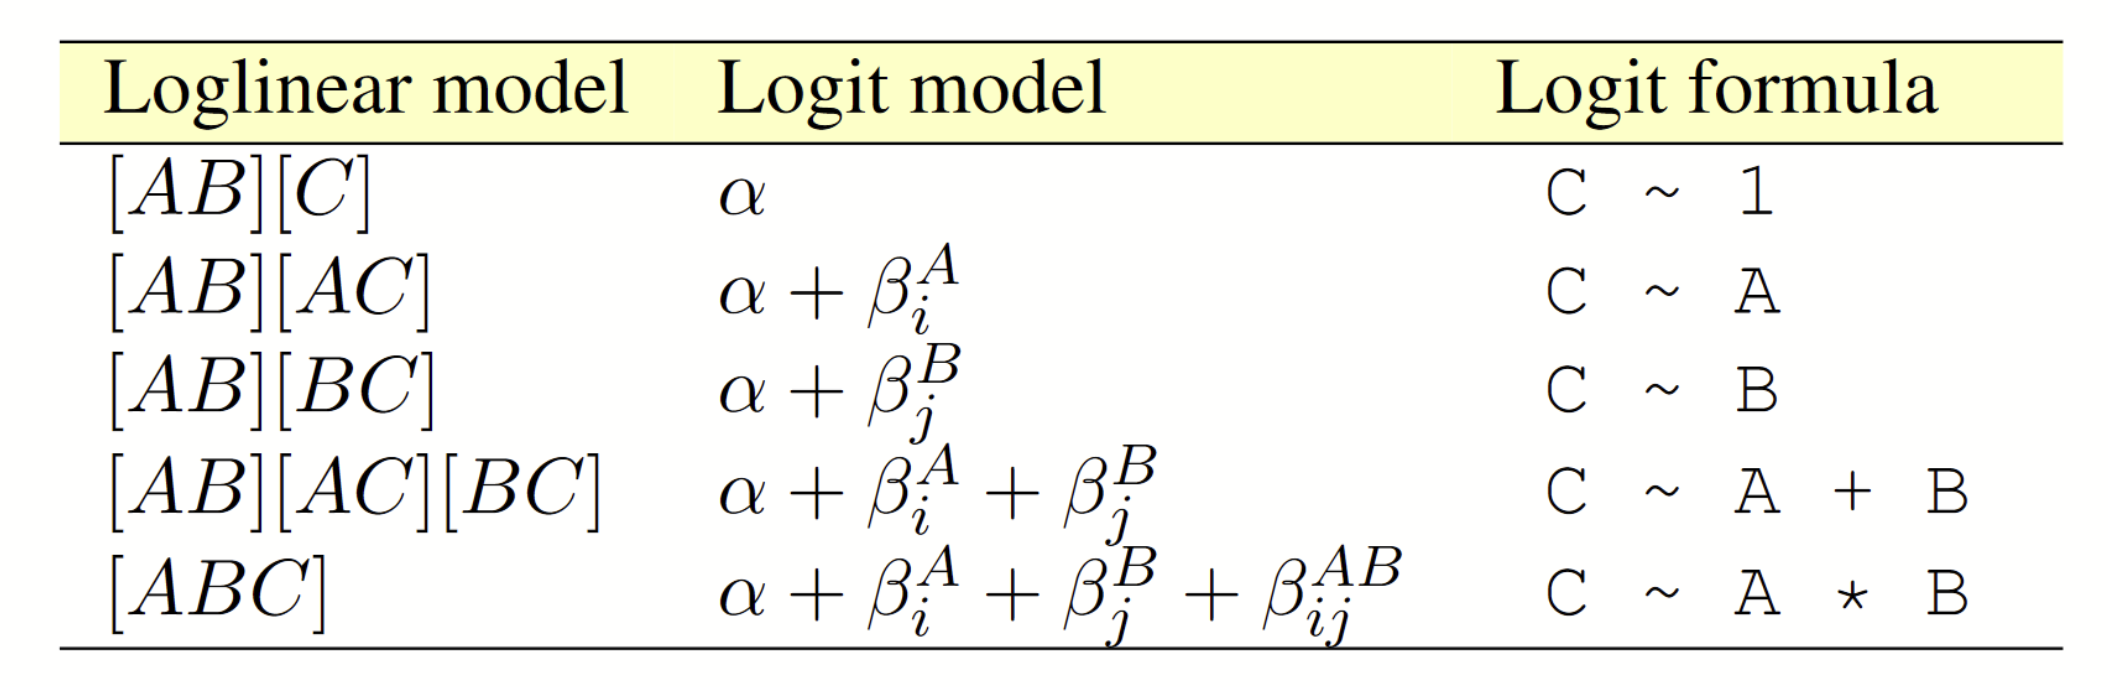

In [ ]:
# Final model
summary(ks_noMO)

In [ ]:
data_frame(coef = names(coef(ks_noMO)),
           coef_value = coef(ks_noMO),
           exp_coef_value = exp(coef(ks_noMO)))


`Method` is conditionally indepenent on `Outcome` given `Size`.

But its marginally dependent. So we can ignore `Size` for a moment and collaps the three-variables table into two-way table.

In [ ]:
kstones

In [ ]:
kstones_2way <- kstones %>%
  group_by(Method,Outcome) %>%
  summarize(Counts = sum(Counts)) %>%
  ungroup()

kstones_2way
  
ks_2way <- glm(Counts ~ Method + Outcome, family=poisson,data = kstones_2way)
summary(ks_2way)
anova(ks_2way, test="Chisq")


In [ ]:
data.frame(fitted = fitted(ks_noMO), measured = kstones$Counts)

If a conditional independence model is appropriate, then each two-way
table for each level of `Size` considered separately shows independence between
`Method` and `Outcome`. The data can be understood by creating separate tables involving factors `Method` and `Outcome`, one for each level of `Size`.

In [ ]:
kstones

In [ ]:
y <- ifelse(kstones$Outcome=="Success", 1, 0)
ks_bin <- glm(y~Size*Method, family=binomial, weights=Counts, data=kstones)
anova(ks_bin, test="Chisq")
summary(ks_bin)

In [ ]:
kstones_w <- kstones %>%
 mutate(prob_bin = fitted(ks_bin)) %>%
 pivot_wider(names_from = c(Outcome), values_from = Counts) %>%
 mutate(n = Success + Failure,
 #       prob_bin = predict.glm(ks_bin,kstones_w,type = c( "response")),
        Success_fit = round(prob_bin*n),
        Failure_fit = round((1-prob_bin)*n) )
kstones_w  

In [ ]:
ks_bin2 <- glm(cbind(Success,Failure)~Size*Method, family=binomial, data=kstones_w)
anova(ks_bin2, test="Chisq")
summary(ks_bin2)